# 도로 영역을 찾자! - 세그멘테이션 모델 만들기

## 평가 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준
1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가? : KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한사이클이 정상수행되어 세그멘테이션 결과이미지를 제출하였다.
2. U-Net++ 모델이 성공적으로 구현되었는가? : U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상진행되었다.
3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가? : U-Net++ 의 세그멘테이션 결과 사진와 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.

## 실습목표
- 시맨틱 세그멘테이션 데이터셋을 전처리할 수 있습니다.
- 시맨틱 세그멘테이션 모델을 만들고 학습할 수 있습니다.
- 시맨틱 세그멘테이션 모델의 결과를 시각화할 수 있습니다.

## 학습내용
- 시맨틱 세그멘테이션 데이터셋
- 시맨틱 세그멘테이션 모델
- 시맨틱 세그멘테이션 모델 시각화

# 들어가며

- 이번 시간에는 시맨틱 세그멘테이션(semantic segmentation)을 이용해서 자율주행차량이 주행해야 할 도로 영역을 찾는 상황을 가정하고 모델을 만들어보는 시간을 갖겠습니다. 앞서 강의 노드에서는 시맨틱 세그멘테이션을 위한 다양한 모델을 배워보았습니다. 이번 시간에는 U-Net을 사용해서 이미지가 입력되면 도로의 영역을 세그멘테이션 하는 모델을 만들어 볼 것입니다.

- 최종적으로 만들어 볼 모델로 아래와 같은 결과를 만들어주세요! 아래 이미지에서는 입력 이미지 위에 도로 영역으로 인식한 영역을 흰색으로 오버레이 했습니다.

- 실습목표
    - 시맨틱 세그멘테이션 데이터셋을 전처리할 수 있습니다.
    - 시맨틱 세그멘테이션 모델을 만들고 학습할 수 있습니다.
    - 시맨틱 세그멘테이션 모델의 결과를 시각화할 수 있습니다.
- 학습내용
    - 시맨틱 세그멘테이션 데이터셋
    - 시맨틱 세그멘테이션 모델
    - 시맨틱 세그멘테이션 모델 시각화

# 시맨틱 세그멘테이션 데이터셋
## 이미지, 데이터 가져오기
- 먼저 시맨틱 세그멘테이션(semantic segmentation)으로 도로의 영역을 분리하기 위해서는 도로의 영역을 라벨로 가진 데이터셋을 가지고 학습할 수 있도록 파싱해야 합니다. 아래 링크를 통해서 물체 검출(object detection)으로 사용했던 KITTI 데이터셋의 세그멘테이션 데이터를 다운로드 합니다.

- \$ mkdir -p ~/aiffel/semantic_segmentation/data
- \$ wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
- \$ unzip data_semantics.zip -d ~/aiffel/semantic_segmentation/data

- 아래는 데이터셋에서 확인할 수있는 이미지와 라벨입니다. 지금까지 보던 라벨 데이터와 다르게 세그멘테이션 데이터는 이미지 형태의 라벨으로 되어있습니다.



# 데이터 로더(data loader) 만들기
- 이제 이미지와 데이터셋이 주어졌으니 모델을 학습시킬 수 있는 데이터 로더(data loader)를 만들어봅시다. 로더는 입력값 (224, 224), 출력값 (224, 244) 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱해야 합니다.

- 이때 데이터 로더에 augmentation을 적용해 봅시다. 오늘은 파이썬에서 많이 사용되는 albumentations을 사용해 보겠습니다. 하지만 Augmentation의 경우 imgaug 등 다른 라이브러리를 활용하셔도 됩니다.

- 시맨틱 세그멘테이션의 이미지 라벨의 각 pixel 값은 의미를 갖습니다. 그렇다면 오늘 우리가 시맨틱 세그멘테이션으로 찾아내야 할 도로의 label은  어떤 값일까요? 7입니다. 

- \$ pip install albumentations

- 또한 학습셋의 일정량을 검증 데이터셋(validation dataset)으로 활용할 수 있도록 해야 합니다.

- 만든 후에는 직접 데이터셋이 잘 파싱되어 나오는지 꼭 확인해보세요. 데이터셋에 오류가 없어야 성능이 안 나오더라도 문제를 찾아내기 쉽습니다.

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

import warnings
warnings.filterwarnings("ignore")

- Albumentation 의 사용법을 간단히 알아보겠습니다. 아래는 Albumentation에서 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 Compose()의 활용예입니다. imgaug의 Somtimes()와 유사한 기능입니다.

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

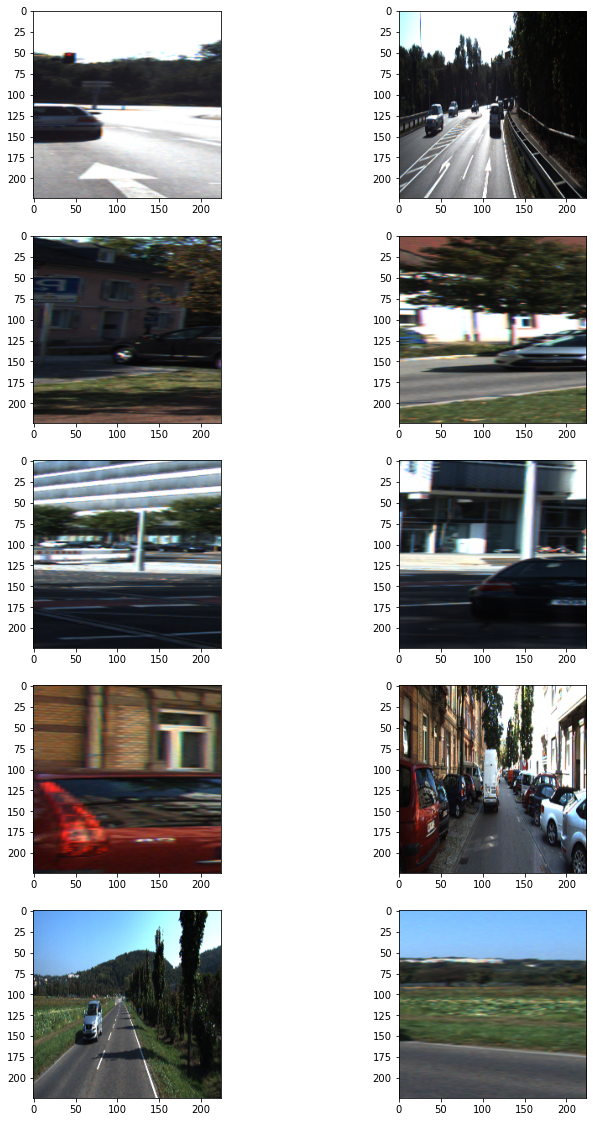

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
plt.show()

이제 데이터셋을 구성해 봅시다. 이번에는 tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성해 보겠습니다.

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    def __init__(self,
                dir_path,
                batch_size = 4,
                img_size=(224,224,3),
                output_size=(224,224),
                is_train=True,
                augmentation=None):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        #load_dataset()을 통해서 kitti dataset의 directory path에서
        #라벨과 이미지를 확인한다.
        self.data = self.load_dataset()
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.    
        input_images = glob(os.path.join(self.dir_path, "image_2","*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic","*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]
        if self.is_train:
            return data[:-30]
        return data[-30:]
    def __len__(self):
        return math.ceil(len(self.data)/self.batch_size)
    def __getitem__(self, index):
        #입력과 출력을 만든다.
        #입력은 resize 및 augmentation이 적용된 input image이고
        #출력은 semantic label이다.
        batch_data = self.data[
            index*self.batch_size : (index+1)*self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        #data에서 배치만큼 가져온 것 (input과 label image가 같이 들어있다)
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image" : _input,
                "mask" : _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        return inputs, outputs
    def on_epoch_end(self):
        #한 에폭이 끝나면 실행되는 함수이다. 학습중인 경우에 순서를 random shuffle하도록 적용하는
        #것을 볼수 있다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(dir_path,
                                augmentation=augmentation,)
test_generator = KittiGenerator(dir_path,
                                augmentation=test_preproc,
                                is_train=False
                               )

In [6]:
dir_path

'/home/aiffel0042/aiffel/semantic_segmentation/data/training'

# 시맨틱 세그멘테이션 모델

![title](u-net_1kfpgqE.max-800x600.png) 

# 모델 구조 만들기
- 시맨틱 세그멘테이션을 위한 모델을 만들어주세요. 세그멘테이션 모델 중 구조상 비교적 구현이 단순한 U-Net을 구현해 봅시다.

- 이때 입력 이미지의 크기는 위에서 만든 데이터셋에 맞춰서 만들어주세요.

- 사용에 필요한 레이어와 연산은 다음과 같습니다. 그리고 필요에 따라서 Dropout등의 다른 레이어를 적용해보세요.

    - Conv2D, UpSampling2D, MaxPooling2D, concatenate

In [16]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    model = Model(inputs = inputs, outputs = conv10)
    return model

In [17]:
model = build_model()
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

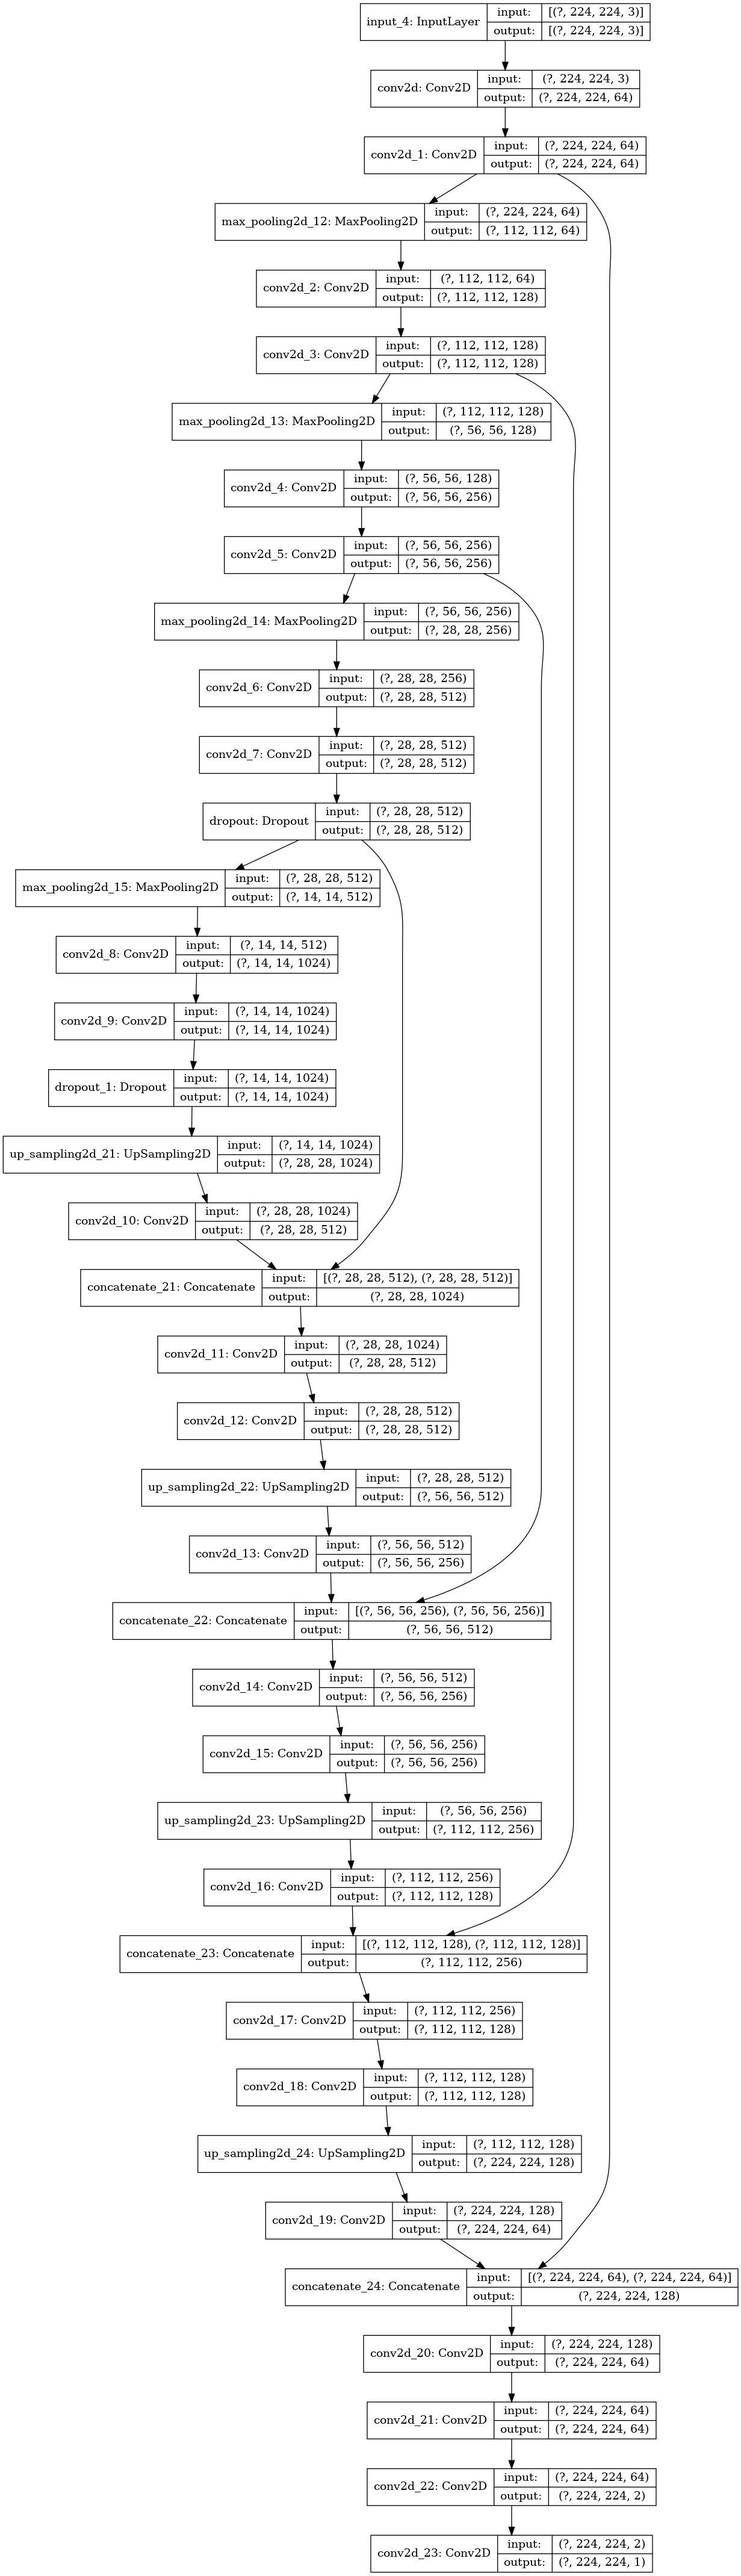

In [18]:
tf.keras.utils.plot_model(model, './UNet.png', show_shapes=True)

## 모델 학습하기
- 이제 모델을 만들었으니 위에서 만들어본 데이터셋과 학습을 해봅시다! 적절한 learning rate와 epoch를 찾아서 모델을 학습하고 저장해주세요.

In [9]:
model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
43/43 [==============================] - 8s 181ms/step - loss: 0.4223 - val_loss: 0.3950
Epoch 2/100
43/43 [==============================] - 8s 180ms/step - loss: 0.3086 - val_loss: 0.3271
Epoch 3/100
43/43 [==============================] - 8s 185ms/step - loss: 0.2848 - val_loss: 0.3071
Epoch 4/100
43/43 [==============================] - 8s 185ms/step - loss: 0.2835 - val_loss: 0.3284
Epoch 5/100
43/43 [==============================] - 8s 189ms/step - loss: 0.2861 - val_loss: 0.3104
Epoch 6/100
43/43 [==============================] - 8s 187ms/step - loss: 0.2618 - val_loss: 0.2729
Epoch 7/100
43/43 [==============================] - 8s 187ms/step - loss: 0.2495 - val_loss: 0.2614
Epoch 8/100
43/43 [==============================] - 8s 189ms/step - loss: 0.2430 - val_loss: 0.3601
Epoch 9/100
43/43 [==============================] - 8s 189ms/step - loss: 0.2449 - val_loss: 0.2915
Epoch 10/100
43

## 시맨틱 세그멘테이션 모델 시각화
- 이번에는 학습한 모델의 결과를 눈으로 확인해볼 차례입니다. 테스트 셋은 이미지를 제공하지만 정답 데이터를 제공하지 않으니 눈으로 확인할 수 있도록 모델이 추론(inference)한 결과를 우리의 눈으로 볼 수 있는 세그멘테이션 이미지로 만들어주세요!

- 이때 입력 이미지와 라벨을 한번에 볼 수 있도록 모델의 출력값을 입력 이미지 위에 겹쳐서 보이기, 즉 오버레이(overray) 해 주세요. PIL 패키지를 사용하신다면 Image.blend를 활용하실 수 있습니다.

- (참고) 이전 스텝에서 저장된 모델은 이후 아래와 같이 로드해서 활용할 수 있습니다.
- model = tf.keras.models.load_model(model_path)

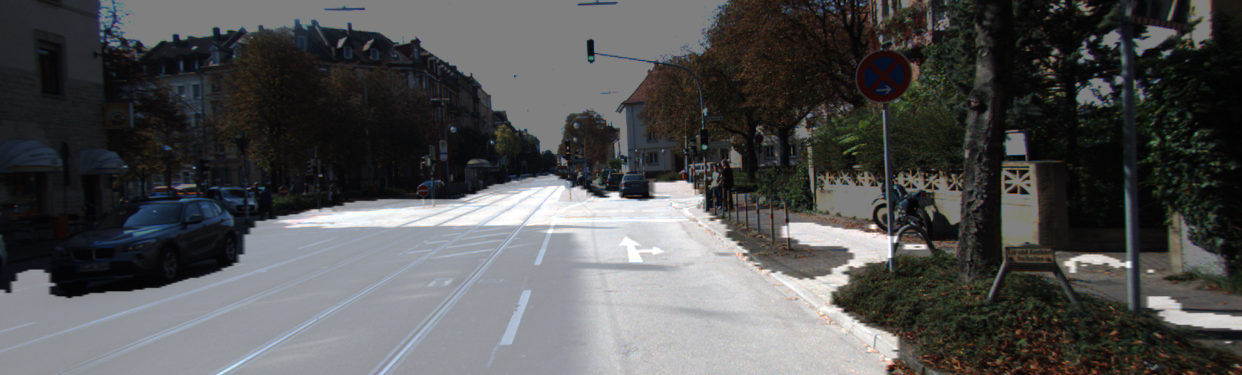

In [10]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output
 

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [30]:
dir_path

'/home/aiffel0042/aiffel/semantic_segmentation/data/training'

- 세그멘테이션이 성능을 정량적으로 측정하기 위한 방법으로 IoU(Intersection over Union)를 계산하게 됩니다. IoU를 계산하는 방법은 지난 시간에 소개한 바 있으므로 해당 내용을 활용하여 구현해 보겠습니다.

- IoU를 계산하려면 모델이 도로 영역이라고 판단한 부분이 1로, 나머지 부분이 0으로 표시된 행렬, 그리고 라벨 데이터에서 도로 영역이 1, 나머지 부분이 0으로 표시된 행렬이 필요합니다. 각각을 prediction, target이라고 불렀을 때 이를 계산하는 함수를 구현해 보겠습니다. 위에 구현했던 get_output을 좀더 확장해서 output, prediction, target을 함께 리턴하도록 구현해 봅시다.

In [11]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [12]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [13]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.882997


0.8829968723343758

# 프로젝트 : 개선된 U-Net 모델 만들기
- U-Net을 통한 시맨틱 세그멘테이션 결과가 충분히 만족스러우신가요? 어느정도 동작하는 것 같긴 하지만 좀더 개선할 여지도 보일 것입니다.

- 2018년에 U-Net++라는 논문이 나왔습니다. 이 논문은 기존에 아주 단순하면서도 세그멘테이션에서 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델입니다.

- 그래서 모델의 구조 자체는 아래 그림에서 보는 것처럼 별다른 설명이 없이도 직관적으로 이해가 가능한 수준입니다. 오늘 소개되었던 U-Net의 모델 코드를 조금만 수정 확장하면 충분히 구현할 수 있을 것입니다. 그래서 오늘의 과제는 바로 U-Net++ 모델을 스스로의 힘으로 직접 구현해 보고, U-Net을 활용했던 도로 세그멘테이션 태스크에 적용하여 U-Net을 썼을 때보다 성능이 향상되었음을 확인해 보는 것입니다. 정성적으로는 두 모델의 세그멘테이션 결과를 시각화해서 비교해 볼 수 있을 것이고, 정량적으로는 동일 이미지에 대한 IoU값을 비교해 보면 될 것입니다.

![title](GC-5-P-UNPP.max-800x600.png)

# Step 1. KITTI 데이터셋 수집과 구축
- 다운받아 둔 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 내부적인 메모리 사용량이 U-Net보다 꽤 많아집니다. 8GB의 GPU 메모리를 가진 모델의 경우 학습데이터의 배치 사이즈를 16->4 로 줄여서 설정하시기를 권합니다.


In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

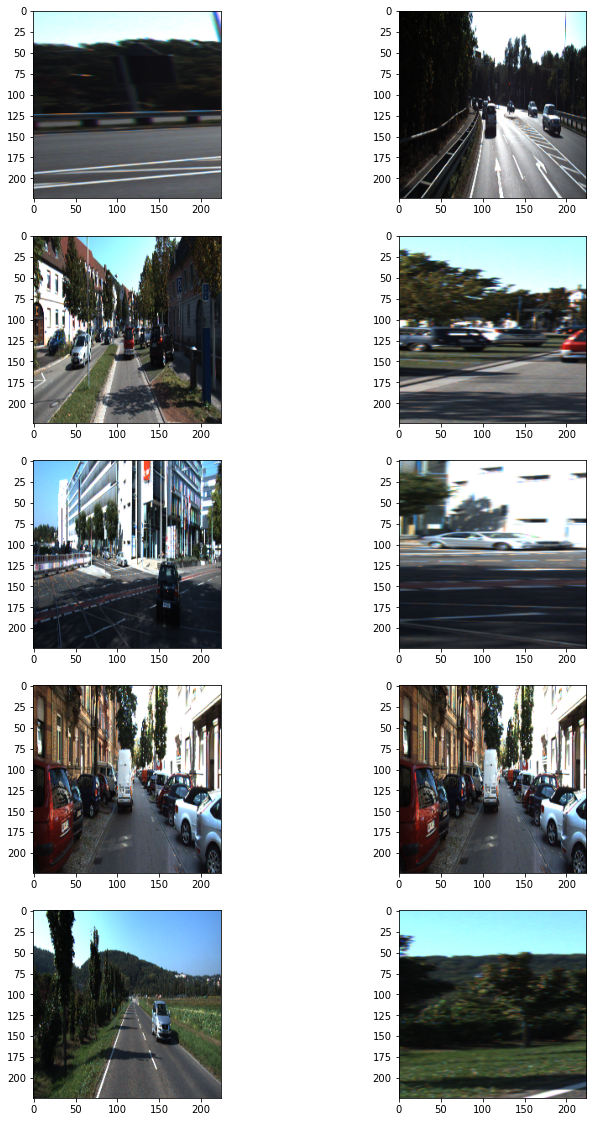

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    def __init__(self,
                dir_path,
                batch_size = 4,
                img_size=(224,224,3),
                output_size=(224,224),
                is_train=True,
                augmentation=None):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        #load_dataset()을 통해서 kitti dataset의 directory path에서
        #라벨과 이미지를 확인한다.
        self.data = self.load_dataset()
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.    
        input_images = glob(os.path.join(self.dir_path, "image_2","*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic","*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]
        if self.is_train:
            return data[:-30]
        return data[-30:]
    def __len__(self):
        return math.ceil(len(self.data)/self.batch_size)
    def __getitem__(self, index):
        #입력과 출력을 만든다.
        #입력은 resize 및 augmentation이 적용된 input image이고
        #출력은 semantic label이다.
        batch_data = self.data[
            index*self.batch_size : (index+1)*self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        #data에서 배치만큼 가져온 것 (input과 label image가 같이 들어있다)
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image" : _input,
                "mask" : _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        return inputs, outputs
    def on_epoch_end(self):
        #한 에폭이 끝나면 실행되는 함수이다. 학습중인 경우에 순서를 random shuffle하도록 적용하는
        #것을 볼수 있다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(dir_path,
                                augmentation=augmentation,)
test_generator = KittiGenerator(dir_path,
                                augmentation=test_preproc,
                                is_train=False
                               )

# Step 2. U-Net++ 모델의 구현
- U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다.
- 그 외 적절히 U-Net이 백본구조, 기타 파라미터 변경 등을 통해 추가적인 성능향상이 가능할수도 있습니다.

![title](NestedU-net-max-800x600.png)

## Re-designed Skip Pathways

![title](1_RNFWpT9cHcioQ_meoIhiDg.png)

#### H() is a convolution operation followed by an activation function
#### U() denotes an up-sampling layer
#### [ ] denotes the concatenation layer
![title](1_dGm3GAy0grdBn258YYzyfQ.png)


## Deep Supervision

![title](1_4i5uOQkUU6SnxRzxGcbZjQ.png)


In [8]:
def build_NestedUNet_model(input_shape=(224, 224, 3)):
    
    n1 = 32
    filters = [n1, n1*2, n1*4, n1*8, n1*16]
    
    inputs = Input(input_shape)
    
    # Left Backbone CONV X0,0
    conv0_0_1 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_0_1')(inputs)
    bn0_0_1 = BatchNormalization()(conv0_0_1)
    act0_0_1 = Activation('relu')(bn0_0_1)
    conv0_0_2 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_0_2')(act0_0_1)
    bn0_0_2 = BatchNormalization()(conv0_0_2)
    conv0_0 = Activation('relu')(bn0_0_2)
    
    # Left Backbone CONV X1,0
    conv0_0_D = MaxPooling2D(strides=2)(conv0_0) # 내려가는 부분 Down으로 표기
    conv1_0_1 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_0_1')(conv0_0_D)
    bn1_0_1 = BatchNormalization()(conv1_0_1)
    act1_0_1 = Activation('relu')(bn1_0_1)
    conv1_0_2 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_0_2')(act1_0_1)
    bn1_0_2 = BatchNormalization()(conv1_0_2)
    conv1_0 = Activation('relu')(bn1_0_2)
    
    # Left Backbone CONV X2,0
    conv1_0_D = MaxPooling2D(strides=2)(conv1_0)  # 내려가는 부분 Down으로 표기
    conv2_0_1 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_0_1')(conv1_0_D)
    bn2_0_1 = BatchNormalization()(conv2_0_1)
    act2_0_1 = Activation('relu')(bn2_0_1)
    conv2_0_2 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_0_2')(act2_0_1)
    bn2_0_2 = BatchNormalization()(conv2_0_2)
    conv2_0 = Activation('relu')(bn2_0_2)
    
    # Left Backbone CONV X3,0
    conv2_0_D = MaxPooling2D(strides=2)(conv2_0)  # 내려가는 부분 Down으로 표기
    conv3_0_1 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_0_1')(conv2_0_D)
    bn3_0_1 = BatchNormalization()(conv3_0_1)
    act3_0_1 = Activation('relu')(bn3_0_1)
    conv3_0_2 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_0_2')(act3_0_1)
    bn3_0_2 = BatchNormalization()(conv3_0_2)
    conv3_0 = Activation('relu')(bn3_0_2)
    
    # Left Backbone CONV X4,0
    conv3_0_D = MaxPooling2D(strides=2)(conv3_0)  # 내려가는 부분 Down으로 표기
    conv4_0_1 = Conv2D(filters[4], 3, padding='same', kernel_initializer='he_normal', name='conv4_0_1')(conv3_0_D)
    bn4_0_1 = BatchNormalization()(conv4_0_1)
    act4_0_1 = Activation('relu')(bn4_0_1)
    conv4_0_2 = Conv2D(filters[4], 3, padding='same', kernel_initializer='he_normal', name='conv4_0_2')(act4_0_1)
    bn4_0_2 = BatchNormalization()(conv4_0_2)
    conv4_0 = Activation('relu')(bn4_0_2)  

    # The First Middle Connection CONV X0,1
    conv1_0_U = UpSampling2D()(conv1_0)   # 올라가는 부분 UP으로 표기
    conv0_1_R = Concatenate()([conv0_0, conv1_0_U])  # 오른쪽으로 가는 부분 Right으로 표기   
    conv0_1_1 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_1_1')(conv0_1_R)
    bn0_1_1 = BatchNormalization()(conv0_1_1)
    act0_1_1 = Activation('relu')(bn0_1_1)
    conv0_1_2 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_1_2')(act0_1_1)
    bn0_1_2 = BatchNormalization()(conv0_1_2)
    conv0_1 = Activation('relu')(bn0_1_2)
    
    # The First Middle Connection CONV X1,1
    conv2_0_U = UpSampling2D()(conv2_0)   # 올라가는 부분 UP으로 표기
    conv1_1_R = Concatenate()([conv1_0, conv2_0_U])  # 오른쪽으로 가는 부분 Right으로 표기
    conv1_1_1 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_1_1')(conv1_1_R)
    bn1_1_1 = BatchNormalization()(conv1_1_1)
    act1_1_1 = Activation('relu')(bn1_1_1)
    conv1_1_2 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_1_2')(act1_1_1)
    bn1_1_2 = BatchNormalization()(conv1_1_2)
    conv1_1 = Activation('relu')(bn1_1_2)
    
    # The First Middle Connection CONV X2,1
    conv3_0_U = UpSampling2D()(conv3_0)   # 올라가는 부분 UP으로 표기
    conv2_1_R = Concatenate()([conv2_0, conv3_0_U])   # 오른쪽으로 가는 부분 Right으로 표기
    conv2_1_1 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_1_1')(conv2_1_R)
    bn2_1_1 = BatchNormalization()(conv2_1_1)
    act2_1_1 = Activation('relu')(bn2_1_1)
    conv2_1_2 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_1_2')(act2_1_1)
    bn2_1_2 = BatchNormalization()(conv2_1_2)
    conv2_1 = Activation('relu')(bn2_1_2)
    
    # Right Backbone CONV X3,1
    conv4_0_U = UpSampling2D()(conv4_0)   # 올라가는 부분 UP으로 표기
    conv3_1_R = Concatenate()([conv3_0, conv4_0_U])   # 오른쪽으로 가는 부분 Right으로 표기 
    conv3_1_1 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_1_1')(conv3_1_R)
    bn3_1_1 = BatchNormalization()(conv3_1_1)
    act3_1_1 = Activation('relu')(bn3_1_1)
    conv3_1_2 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_1_2')(act3_1_1)
    bn3_1_2 = BatchNormalization()(conv3_1_2)
    conv3_1 = Activation('relu')(bn3_1_2)
    
    # The Second Middle Connection CONV X0,2    
    conv1_1_U = UpSampling2D()(conv1_1)   # 올라가는 부분 UP으로 표기
    conv0_2_R = Concatenate()([conv0_0, conv0_1, conv1_1_U])   # 오른쪽으로 가는 부분 Right으로 표기
    conv0_2_1 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_2_1')(conv0_2_R)
    bn0_2_1 = BatchNormalization()(conv0_2_1)
    act0_2_1 = Activation('relu')(bn0_2_1)
    conv0_2_2 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_2_2')(act0_2_1)
    bn0_2_2 = BatchNormalization()(conv0_2_2)
    conv0_2 = Activation('relu')(bn0_2_2)
    
    # The Second Middle Connection CONV X1,2
    conv2_1_U = UpSampling2D()(conv2_1)   # 올라가는 부분 UP으로 표기
    conv1_2_R = Concatenate()([conv1_0, conv1_1, conv2_1_U])   # 오른쪽으로 가는 부분 Right으로 표기
    conv1_2_1 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_2_1')(conv1_2_R)
    bn1_2_1 = BatchNormalization()(conv1_2_1)
    act1_2_1 = Activation('relu')(bn1_2_1)
    conv1_2_2 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_2_2')(act1_2_1)
    bn1_2_2 = BatchNormalization()(conv1_2_2)
    conv1_2 = Activation('relu')(bn1_2_2)
    
    # Right Backbone CONV X2,2
    conv3_1_U = UpSampling2D()(conv3_1)   # 올라가는 부분 UP으로 표기
    conv2_2_R = Concatenate()([conv2_0, conv2_1, conv3_1_U])   # 오른쪽으로 가는 부분 Right으로 표기
    conv2_2_1 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_2_1')(conv2_2_R)
    bn2_2_1 = BatchNormalization()(conv2_2_1)
    act2_2_1 = Activation('relu')(bn2_2_1)
    conv2_2_2 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_2_2')(act2_2_1)
    bn2_2_2 = BatchNormalization()(conv2_2_2)
    conv2_2 = Activation('relu')(bn2_2_2)
    
    # The Third Middle Connection CONV X0,3
    conv1_2_U = UpSampling2D()(conv1_2)   # 올라가는 부분 UP으로 표기
    conv0_3_R = Concatenate()([conv0_0, conv0_1, conv0_2, conv1_2_U])  # 오른쪽으로 가는 부분 Right으로 표기
    conv0_3_1 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_3_1')(conv0_3_R)
    bn0_3_1 = BatchNormalization()(conv0_3_1)
    act0_3_1 = Activation('relu')(bn0_3_1)
    conv0_3_2 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_3_2')(act0_3_1)
    bn0_3_2 = BatchNormalization()(conv0_3_2)
    conv0_3 = Activation('relu')(bn0_3_2)
    
    # Right Backbone CONV X1,3
    conv2_2_U = UpSampling2D()(conv2_2)   # 올라가는 부분 UP으로 표기
    conv1_3_R = Concatenate()([conv1_0, conv1_1, conv1_2, conv2_2_U])  # 오른쪽으로 가는 부분 Right으로 표기
    conv1_3_1 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_3_1')(conv1_3_R)
    bn1_3_1 = BatchNormalization()(conv1_3_1)
    act1_3_1 = Activation('relu')(bn1_3_1)
    conv1_3_2 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_3_2')(act1_3_1)
    bn1_3_2 = BatchNormalization()(conv1_3_2)
    conv1_3 = Activation('relu')(bn1_3_2)
    
    # Right Backbone CONV X0,4
    conv1_3_U = UpSampling2D()(conv1_3)  # 올라가는 부분 UP으로 표기                                      
    conv0_4_R = Concatenate()([conv0_0, conv0_1, conv0_2, conv0_3, conv1_3_U])  # 오른쪽으로 가는 부분 Right으로 표기
    conv0_4_1 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_4_1')(conv0_4_R)
    bn0_4_1 = BatchNormalization()(conv0_4_1)
    act0_4_1 = Activation('relu')(bn0_4_1)
    conv0_4_2 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_4_2')(act0_4_1)
    bn0_4_2 = BatchNormalization()(conv0_4_2)
    conv0_4 = Activation('relu')(bn0_4_2)
    
    output = Conv2D(1, 1, activation='sigmoid', name='final')(conv0_4)
    
    model = Model(inputs = inputs, outputs = output)
    
    return model

In [14]:
model = build_NestedUNet_model()
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv0_0_1 (Conv2D)              (None, 224, 224, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 224, 224, 32) 128         conv0_0_1[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 224, 224, 32) 0           batch_normalization_40[0][0]     
_______________________________________________________________________________________

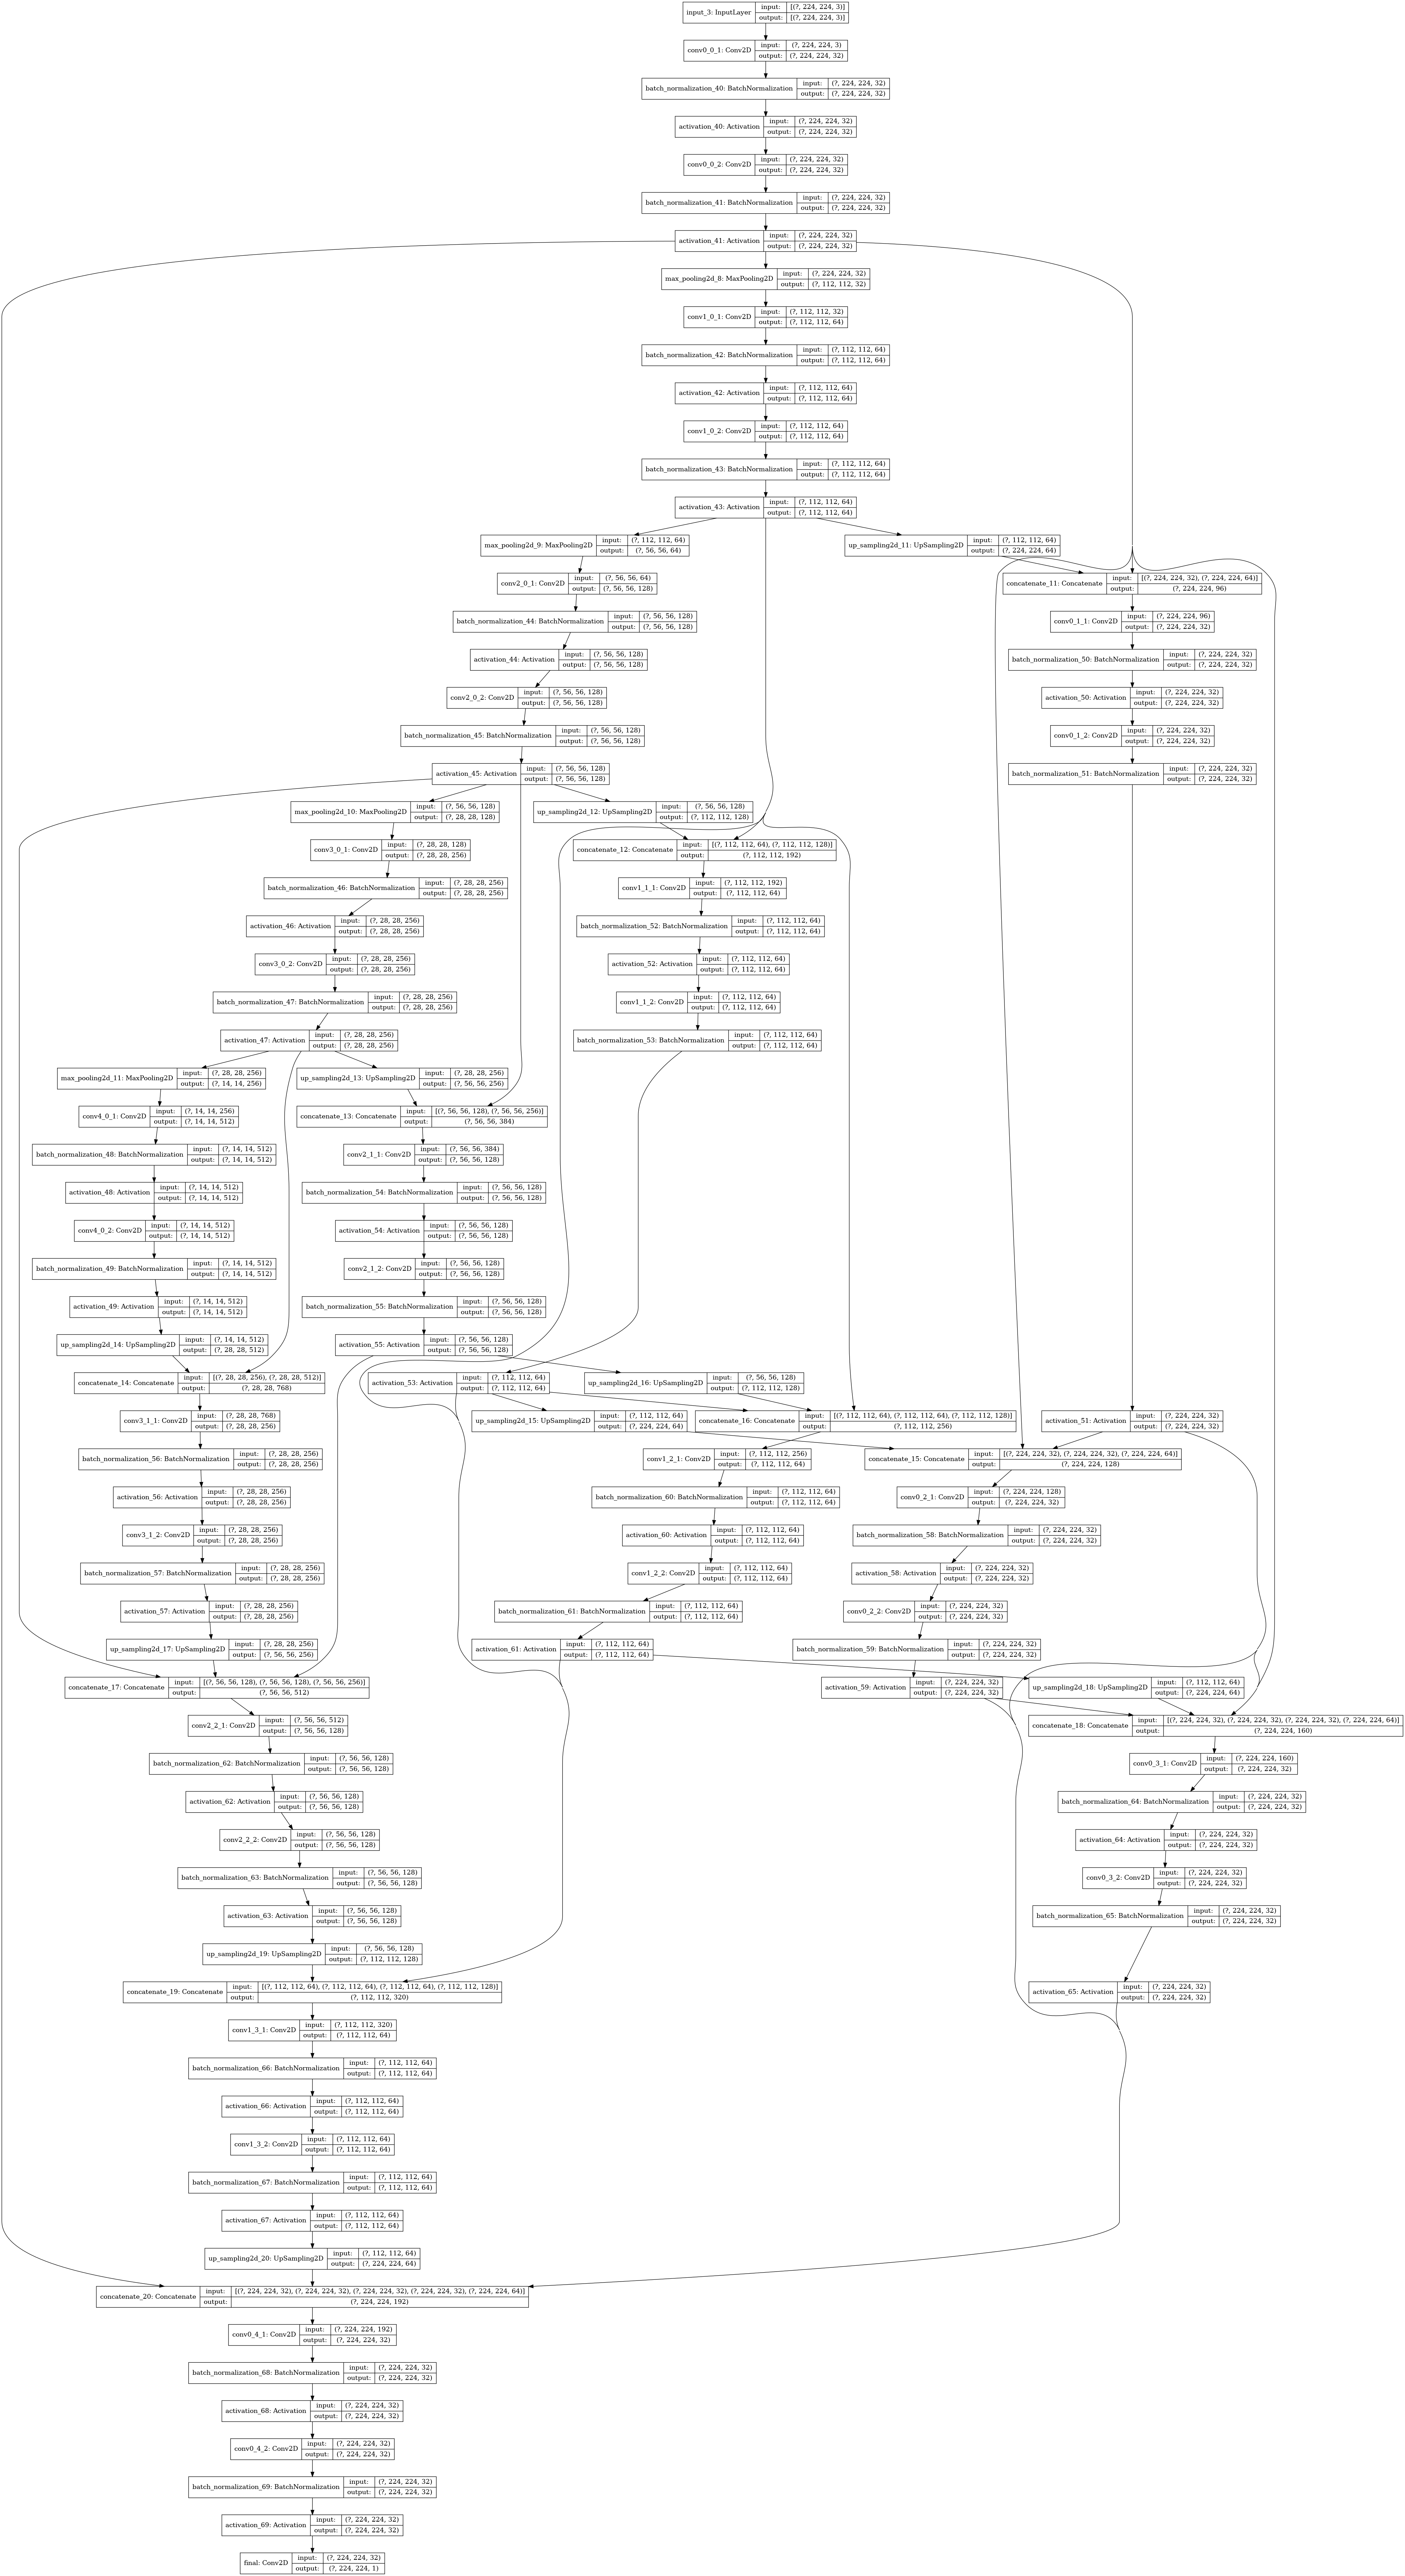

In [15]:
tf.keras.utils.plot_model(model, './NestedUNet.png', show_shapes=True)

In [9]:
model = build_NestedUNet_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=200,
 )

model_path = dir_path + '/seg_model_NestedUNet_unet.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
43/43 [==============================] - 8s 179ms/step - loss: 0.7225 - val_loss: 1.6955
Epoch 2/200
43/43 [==============================] - 7s 164ms/step - loss: 0.4847 - val_loss: 5.3358
Epoch 3/200
43/43 [==============================] - 7s 163ms/step - loss: 0.4101 - val_loss: 1.9953
Epoch 4/200
43/43 [==============================] - 7s 162ms/step - loss: 0.3396 - val_loss: 0.6496
Epoch 5/200
43/43 [==============================] - 7s 172ms/step - loss: 0.3270 - val_loss: 0.5665
Epoch 6/200
43/43 [==============================] - 7s 159ms/step - loss: 0.3219 - val_loss: 0.3793
Epoch 7/200
43/43 [==============================] - 7s 160ms/step - loss: 0.3309 - val_loss: 0.3673
Epoch 8/200
43/43 [==============================] - 7s 161ms/step - loss: 0.2727 - val_loss: 0.2726
Epoch 9/200
43/43 [==============================] - 7s 161ms/step - loss: 0.2765 - val_loss: 0.2961
Epoch 10/200
43

43/43 [==============================] - 7s 168ms/step - loss: 0.1295 - val_loss: 0.1668
Epoch 77/200
43/43 [==============================] - 7s 167ms/step - loss: 0.0993 - val_loss: 0.1662
Epoch 78/200
43/43 [==============================] - 7s 167ms/step - loss: 0.1103 - val_loss: 0.1661
Epoch 79/200
43/43 [==============================] - 7s 169ms/step - loss: 0.1041 - val_loss: 0.1456
Epoch 80/200
43/43 [==============================] - 7s 169ms/step - loss: 0.1048 - val_loss: 0.1657
Epoch 81/200
43/43 [==============================] - 7s 169ms/step - loss: 0.1034 - val_loss: 0.1575
Epoch 82/200
43/43 [==============================] - 7s 167ms/step - loss: 0.1084 - val_loss: 0.1489
Epoch 83/200
43/43 [==============================] - 7s 168ms/step - loss: 0.1173 - val_loss: 0.1582
Epoch 84/200
43/43 [==============================] - 7s 167ms/step - loss: 0.0931 - val_loss: 0.1713
Epoch 85/200
43/43 [==============================] - 7s 168ms/step - loss: 0.0969 - val_loss: 

Epoch 156/200
43/43 [==============================] - 7s 169ms/step - loss: 0.0624 - val_loss: 0.1958
Epoch 157/200
43/43 [==============================] - 7s 169ms/step - loss: 0.0627 - val_loss: 0.1542
Epoch 158/200
43/43 [==============================] - 7s 170ms/step - loss: 0.0624 - val_loss: 0.1722
Epoch 159/200
43/43 [==============================] - 7s 169ms/step - loss: 0.0591 - val_loss: 0.2003
Epoch 160/200
43/43 [==============================] - 7s 170ms/step - loss: 0.0722 - val_loss: 0.2064
Epoch 161/200
43/43 [==============================] - 7s 170ms/step - loss: 0.0696 - val_loss: 0.1810
Epoch 162/200
43/43 [==============================] - 7s 170ms/step - loss: 0.0607 - val_loss: 0.2008
Epoch 163/200
43/43 [==============================] - 7s 170ms/step - loss: 0.0812 - val_loss: 0.2314
Epoch 164/200
43/43 [==============================] - 7s 169ms/step - loss: 0.0837 - val_loss: 0.1564
Epoch 165/200
43/43 [==============================] - 7s 170ms/step - lo

# Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석
- 두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

# U-Net++  100 epoch 학습 결과

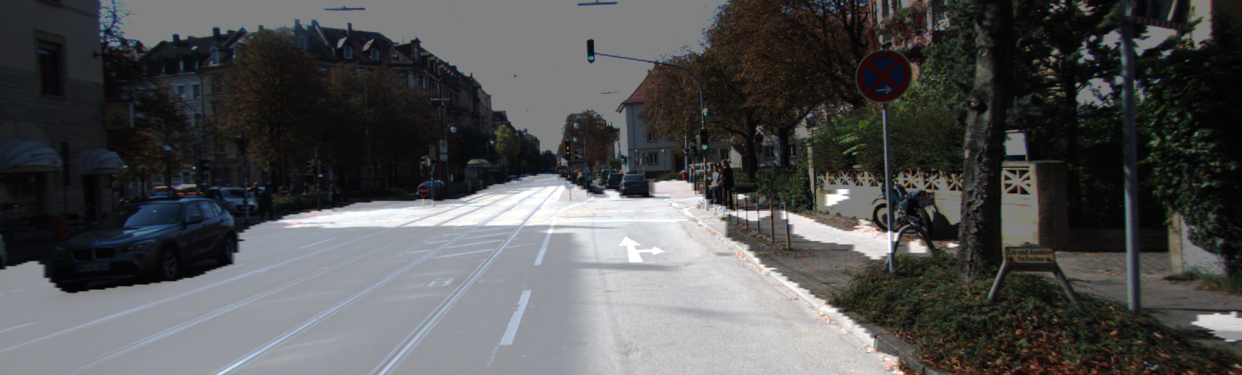

In [26]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output
 

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [27]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [28]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)
        return output, prediction, target
    else:
        return output, prediction, _

In [29]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.905633


0.9056331940642559

# U-Net++  200 epoch 학습 결과

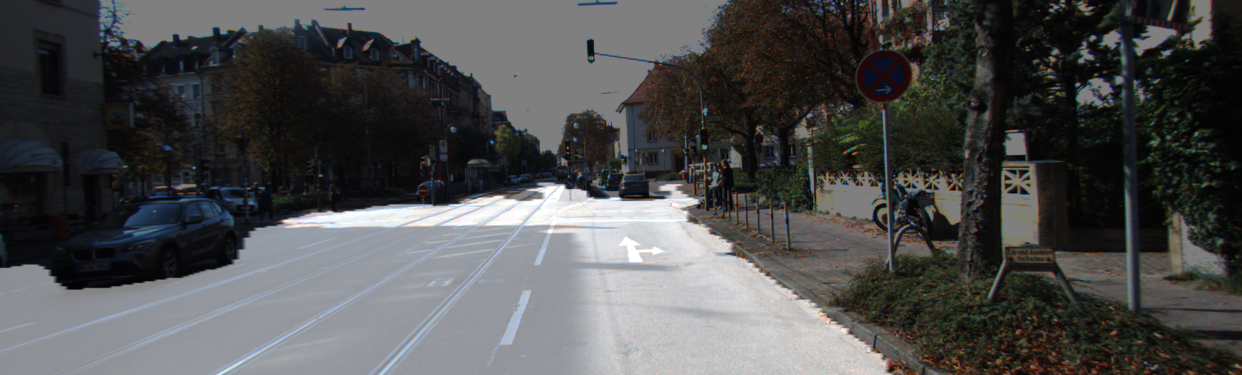

In [10]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output
 

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [11]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [12]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [13]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.960130


0.9601298099211868

# 결과 정리

## IOU 결과는 Unet보다는 Unet++가 좋다. 

- Unet 100 epochs: IoU ***0.882997***
- Unet++ 100 epochs: IoU ***0.905633***
- Unet++ 200 epochs: IoU ***0.960130***

## 결과 이미지
## 1. Unet 100 epochs : 오른쪽 인도를 차도로 잘 못 인식하는 부분이 있었다. 

![title](UNet100epochs.png)

## 2. Unet++ 100 epochs : 오른쪽 인도를 차도로 인식했지만, 도로의 선을 조금 더 잘 잡아냈다. 

![title](UNet++100epochs.png)

## 3. Unet++ 200 epochs : 멀리 있는 도로의 선까지 명확하게 구분해서 잡아냈다. 

![title](UNet++200epochs.png)